In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('simulaciones.csv', nrows=100000)

FileNotFoundError: [Errno 2] File simulaciones.csv does not exist: 'simulaciones.csv'

In [4]:
print(data.shape)
data.head()

(43500, 12)


,Identificador,Numero_agentes,Tipo_red,Agente,Ronda,Estado,Puntaje,Politica,Parametro-0,Parametro-1,Politica_lag,Consistencia
0,0,5,Full,0,0,0,0,7,5,1,NaN,NaN
1,0,5,Full,0,1,1,1,7,5,1,7.0,1.0
2,0,5,Full,0,2,1,1,7,5,1,7.0,1.0
3,0,5,Full,0,3,1,-1,7,5,1,7.0,1.0
4,0,5,Full,0,4,1,-1,7,5,1,7.0,1.0


In [5]:
data_full = data.query('Tipo_red=="Full"').copy()

In [6]:
data_full.Numero_agentes.unique()

array([5], dtype=int64)

In [7]:
experimentos = data_full.groupby('Numero_agentes')['Identificador'].unique()
experimentos = experimentos.apply(len)
experimentos

Numero_agentes
5    29
Name: Identificador, dtype: int64

Medida de asistencia óptima al bar El Farol:

Es un número entre 0 y 1, donde 1 significa que en todas las rondas, la asistencia al bar fue de 0.5; 0 significa que o bien la asistencia en todas las rondas fue 0 o 1.

$$ 1 - 2*\sqrt{\frac{\sum_{r}(Asistencia_{r} - 0.5)^2}{R}}$$

In [8]:
aux = data_full.groupby(['Numero_agentes', 'Identificador', 'Ronda'])['Estado']\
    .sum().reset_index()
aux.columns = ['Numero_agentes',
               'Identificador',
               'Ronda', 
               'Asistencia_total']

# Proporción de asistencia
aux['Asistencia'] = aux['Asistencia_total']/aux['Numero_agentes']
# Distancia al cuadrado entre proporción de asistencia y 0.5
aux['diferencia_con_umbral'] = (aux['Asistencia'] - 0.5)*(aux['Asistencia'] - 0.5)
aux.head()

,Numero_agentes,Identificador,Ronda,Asistencia_total,Asistencia,diferencia_con_umbral
0,5,0,0,0,0.0,0.25
1,5,0,1,2,0.4,0.01
2,5,0,2,1,0.2,0.09
3,5,0,3,5,1.0,0.25
4,5,0,4,5,1.0,0.25


In [9]:
num_rondas = aux.Ronda.max() + 1
num_rondas

300

In [10]:
df = aux.groupby(['Numero_agentes', 'Identificador'])['diferencia_con_umbral'].sum().reset_index()
df['Asistencia_optima'] = df['diferencia_con_umbral']/num_rondas
df['Asistencia_optima'] = 1 - 2 * np.sqrt(df['Asistencia_optima'])
df.head()

,Numero_agentes,Identificador,diferencia_con_umbral,Asistencia_optima
0,5,0,74.60,0.002670
1,5,1,3.08,0.797351
2,5,2,75.00,0.000000
3,5,3,74.44,0.003740
4,5,4,74.20,0.005348


In [11]:
df['Asistencia_optima'].describe()

count    29.000000
mean      0.126848
std       0.283174
min       0.000000
25%       0.002670
50%       0.003740
75%       0.005348
max       0.800000
Name: Asistencia_optima, dtype: float64

Text(0, 0.5, 'Frecuencia')

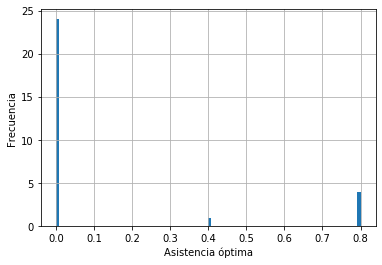

In [12]:
df['Asistencia_optima'].hist(bins = 100)
plt.xlabel('Asistencia óptima')
plt.ylabel('Frecuencia')

Text(0, 0.5, 'Promedio asistencia óptima\nsobre 100 simulaciones')

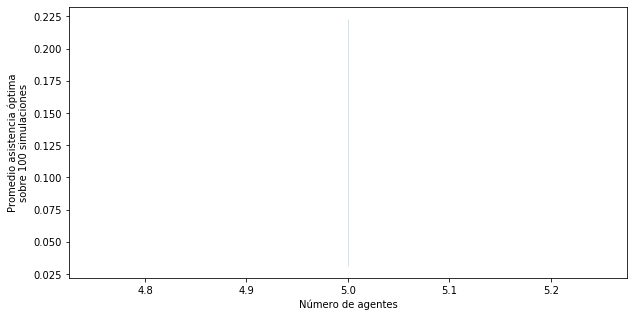

In [13]:
fig = plt.subplots(figsize=(10,5))
sns.lineplot(x=df['Numero_agentes'], y=df['Asistencia_optima'])
plt.xlabel('Número de agentes')
plt.ylabel('Promedio asistencia óptima\nsobre 100 simulaciones')

Medida de recompensa total:

$$\frac{\sum_{a, r} recompensa(a, r)}{A*R}$$

In [14]:
data_recomp = data.groupby(['Numero_agentes', 'Identificador','Ronda'])["Puntaje"].sum().reset_index()
data_recomp["Puntaje"]=data_recomp["Puntaje"]/(num_rondas*data_recomp["Numero_agentes"])
data_recomp

,Numero_agentes,Identificador,Ronda,Puntaje
0,5,0,0,0.000000
1,5,0,1,0.001333
2,5,0,2,0.000667
3,5,0,3,-0.003333
4,5,0,4,-0.003333
...,...,...,...,...
8695,5,28,295,0.000000
8696,5,28,296,0.000000
8697,5,28,297,0.000000
8698,5,28,298,0.000000


Text(0, 0.5, 'Promedio puntaje \nsobre 100 simulaciones')

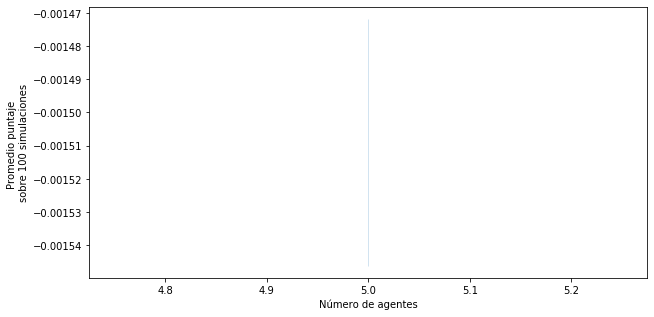

In [15]:
fig = plt.subplots(figsize=(10,5))
sns.lineplot(x=data_recomp['Numero_agentes'], y=data_recomp['Puntaje'])
plt.xlabel('Número de agentes')
plt.ylabel('Promedio puntaje \nsobre 100 simulaciones')

Medida de equidad en al distribución de recursos:

Índice de Gini:

$$\frac{\sum_i\sum_j |recompensa(i) - recompensa(j)|}{2\sum_i\sum_j recompensa(j)}$$

In [21]:
def gini (df, NumAgentes):
    numerador = 0 
    denominador = 0
    for i in range(NumAgentes):
        for j in range(NumAgentes):
            recompensa_i = df[df['Agente'] == i]['Puntaje'].sum()
            recompensa_j = df[df['Agente'] == j]['Puntaje'].sum()
            numerador += np.abs(recompensa_i - recompensa_j)
            denominador += recompensa_j
    denominador *= 2
    return numerador/denominador



In [59]:
#prueba = pd.dataframe['']
Puntaje = [541, 1463, 2445, 3438, 4437, 5401, 6392, 8304, 11904, 22261]
prueba = pd.DataFrame({'Agente':range(len(Puntaje)), 'Puntaje':Puntaje})
prueba.head()

#gini(prueba,5)

,Agente,Puntaje
0,0,541
1,1,1463
2,2,2445
3,3,3438
4,4,4437


In [ ]:
ginis = {}
for ind,grp in data_full.groupby('Indicador'):
    ginis[ind] = gini(grp,grp['Numero_agentes'])

print(ginis)

$$G=|1-\sum_{k=1}^{n-1}(X_{k+1} - X_{k})(Y_{k+1} + Y_{k})|$$


In [11]:
def gini(puntaje, step = 20):
    X = np.arange(0,100+step,step)
    Y = np.percentile(puntaje,X)
    Y /= np.max(Y)
    X = np.arange(0,1+step/100,step/100)
    G = 0
    for k in range(len(X)-1):
        G += (X[k+1] - X[k])*(Y[k+1] + Y[k])
        
    print(X,Y)
    return np.abs(1-G)
gini([1,50,0,0],25)

[0.   0.25 0.5  0.75 1.  ] [0.    0.    0.01  0.265 1.   ]


0.6124999999999999

In [29]:
def gini1(x, w=None):
        # The rest of the code requires numpy arrays.
        x = np.asarray(x) #convierte x en un vector
        sorted_x = np.sort(x) #los organiza de menor a mayor
        n = len(x) #tamaño del vector x
        cumx = np.cumsum(sorted_x, dtype=float)# va haciendo la suma acumulativa
        gini = (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n #esta es una formula muy rara, esta en alternate expression de Wikipedia
        pe_line = np.linspace(start=0.0, stop=1.0, num=len(cumx))
        area_under_lorenz = np.trapz(y=cumx, dx=1/len(cumx)) #area de la suma acumulada, zona azul
        area_under_pe = np.trapz(y=pe_line, dx=1/len(cumx)) #area de la linea perfecta, caso perfecto
        cumx=cumx/cumx[-1] #normalizando para que se vea en la grafica bien
        # The above formula, with all weights equal to 1 simplifies to:
        return gini, pe_line,area_under_lorenz,area_under_pe,cumx

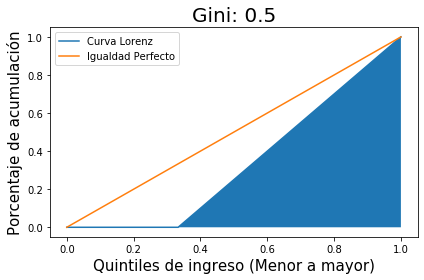

In [30]:
gini, pe_line,area_under_lorenz,area_under_pe,cumx = gini1([1,1,0,0])
from matplotlib import pyplot as plt

plt.plot(pe_line, cumx, label='Curva Lorenz')
plt.plot(pe_line, pe_line, label='Igualdad Perfecto')
plt.fill_between(pe_line, cumx)
plt.title('Gini: {}'.format(gini), fontsize=20)
plt.ylabel('Porcentaje de acumulación', fontsize=15)
plt.xlabel('Quintiles de ingreso (Menor a mayor)', fontsize=15)
plt.legend()
plt.tight_layout()
plt.show()

Links:

* https://stackoverflow.com/questions/31416664/python-gini-coefficient-calculation-using-numpy?noredirect=1&lq=1
* https://stackoverflow.com/questions/48999542/more-efficient-weighted-gini-coefficient-in-python?noredirect=1&lq=1